# [ 순환신경망 실습 1]

### jupyter notebook 단축키
- ctrl+enter: 셀 실행
- shift+enter: 셀 실행 및 다음 셀 이동
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)
- esc: 셀 나가기
- m: 마크다운 셀로 바꾸기

# Generate Dataset

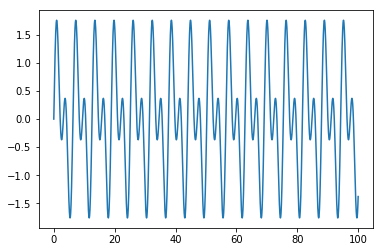

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


# ====== Generating Dataset ====== #
num_data = 2400
t = np.linspace(0.0, 100.0, num_data)
y = np.sin(t) + np.sin(2*t) #+ np.sin(0.4*t)
e = np.random.normal(0, 0.1, num_data)
# y = y + e


seq_len = 10
X = []
y_true = []
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    y_true.append(y[i+seq_len])
    
X = np.array(X)
y_true = np.array(y_true)

X = np.swapaxes(X,0,1)
X = np.expand_dims(X, axis=2)

plt.plot(t, y)

# Model Define

In [2]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size): 
        super(RNN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size
        
        self.u = nn.Linear(self.input_dim, self.hid_dim, bias=False)
        self.w = nn.Linear(self.hid_dim, self.hid_dim, bias=False)
        self.v = nn.Linear(self.hid_dim, self.output_dim, bias=False)
        self.act = nn.Tanh()
        
        self.hidden = self.init_hidden()
        
    def init_hidden(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(batch_size, self.hid_dim)
    
    def forward(self, x):
        h = self.act(self.u(x) + self.w(self.hidden))
        y = self.v(h)
        return y, h

# Train Trigonometric Function

In [3]:
model = RNN(1, 1, 50, 2390)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
epoch = 100

for i in range(epoch):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    
    model.hidden = model.init_hidden()
    
    for x in X:
        x = torch.Tensor(x).float()
        y_true = torch.Tensor(y_true).float()

        y_pred, hidden = model(x)
        model.hidden = hidden

    loss = loss_fn(y_pred.view(-1), y_true.view(-1))
    loss.backward()
    optimizer.step()
    print(loss.item())


1.021073818206787
0.7735557556152344
0.5891657471656799
0.45153090357780457
0.34866946935653687
0.27173683047294617
0.21416625380516052
0.17106415331363678
0.13877588510513306
0.11456891149282455
0.09639924019575119
0.08273805677890778
0.0724421888589859
0.0646573081612587
0.05874534323811531
0.054230011999607086
0.05075603350996971
0.04805855080485344
0.04594021290540695
0.04425404220819473
0.04289063438773155
0.04176855832338333
0.040827229619026184
0.040021590888500214
0.03931812942028046
0.03869191184639931
0.03812439739704132
0.03760179504752159
0.03711383044719696
0.03665286675095558
0.03621319681406021
0.0357905775308609
0.03538183495402336
0.03498459234833717
0.03459706902503967
0.034217916429042816
0.03384613245725632
0.033480942249298096
0.033121753484010696
0.0327681228518486
0.03241969272494316
0.03207618370652199
0.03173738345503807
0.03140310198068619
0.0310731939971447
0.030747536569833755
0.03042602352797985
0.030108559876680374
0.02979506552219391
0.029485462233424187


# Predict Target Function

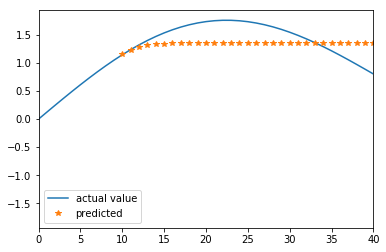

In [4]:
test_X = np.expand_dims(X[:, 0, :], 1)

list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=1)

    for x in test_X:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    list_y_pred.append(y_pred.view(-1).item())
    
    temp_X = list()
    temp_X += list(np.squeeze(test_X))[1:]
    temp_X.append(y_pred.view(-1).item())
    for i in range(2389):
        model.hidden = model.init_hidden(batch_size=1)
        
        temp2_X = torch.unsqueeze(torch.unsqueeze(torch.Tensor(temp_X), 1), 1)
        
        for x in temp2_X:
            y_pred, hidden = model(x)
            model.hidden = hidden
        list_y_pred.append(y_pred.view(-1).item())
        
        temp_X.append(y_pred.view(-1).item())
        temp_X.pop(0)

plt.plot(y, label='actual value')
plt.plot(list(range(10, 2400)), list_y_pred, '*', label='predicted')
plt.xlim(0, 40)
plt.legend()